<h1> SME0300 - Cálculo Numérico </h1>
<h3> Simulação de três corpos </h3>

**Professora:** Livia Souza Freire Grion

**Alunos:**
* Marcos Vinicius Tomás Olegario
* Leonardo de Faria Sales
* Guilherme Santana de Almeida
* Ana Carolina Saggioratto Osello






---



Importando as bibliotecas necessárias:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Função para obter a derivada do vetor de estado:

In [ ]:
def get_dotS(S):
    R_1 = S[0, :2]
    R_2 = S[1, :2]
    R_3 = S[2, :2]

    dotR_1 = S[0, 2:]
    dotR_2 = S[1, 2:]
    dotR_3 = S[2, 2:]

    # Constrói a estrutura do Output
    dotS = np.zeros_like(S)

    # Preenche com as velocidades do estado
    dotS[0, :2] = dotR_1
    dotS[1, :2] = dotR_2
    dotS[2, :2] = dotR_3

    # Módulo dos vetores posição
    r12 = np.linalg.norm(R_2 - R_1) # 1 -> 2
    r13 = np.linalg.norm(R_3 - R_1) # 1 -> 3
    r23 = np.linalg.norm(R_3 - R_2) # 2 -> 3

    # Acelerações de cada corpo
    ddotR_1 = G * m_2 * (R_2 - R_1) / r12**3 + G * m_3 * (R_3 - R_1) / r13**3
    ddotR_2 = G * m_1 * (R_1 - R_2) / r12**3 + G * m_3 * (R_3 - R_2) / r23**3
    ddotR_3 = G * m_1 * (R_1 - R_3) / r13**3 + G * m_2 * (R_2 - R_3) / r23**3

    # Preenche com as acelerações do estado
    dotS[0, 2:] = dotS[0, 2:] + ddotR_1
    dotS[1, 2:] = dotS[1, 2:] + ddotR_2
    dotS[2, 2:] = dotS[2, 2:] + ddotR_3

    return dotS

Função para obter as energias de cada estado:

In [ ]:
def get_energy(S):
    R = S[:, :2]        # Submatriz com todas as posições
    dotR = S[:, 2:]     # Submatriz com todas as velocidades
    masses = np.array([m_1, m_2, m_3]).reshape(3,1) # Matriz com as massas

    # Energia Cinética
    KE = 0.5 * np.sum(np.sum(masses * dotR**2 ))

    # Energia Potencial
    PE = 0
    for i, j in [(0, 1), (0, 2), (1, 2)]:
        r = np.linalg.norm(R[i] - R[j])
        PE -= masses[i] * masses[j] / r
    PE *= G

    return KE, PE

### Métodos de solução de EDO

Método Runge-Kutta de 4ª ordem:



In [ ]:
def rk4(S, dt, func):

    # Calculando termos do método RK4
    k1 = func(S)
    k2 = func(S + 0.5*k1*dt)
    k3 = func(S + 0.5*k2*dt)
    k4 = func(S + k3*dt)

    # Atualiza S
    S_prime = (1/6.)*(k1 + 2*k2 + 2*k3 + k4)

    return S + S_prime * dt

Método Adams-Moulton de 4ª ordem:

In [ ]:
def norm(vec):
    return np.linalg.norm(vec)

def adams_moulton_4(history, iter, dt, func):
    S0 = history[iter-4]
    S1 = history[iter-3]
    S2 = history[iter-2]
    S3 = history[iter-1]

    # Calcula o chute inicial pelo método explicito de Adams-Bashforth
    S4_0 = S3 + (dt/24) * (55 * func(S3) - 59 * func(S2) + 37 * func(S1) - 9 * func(S0))

    tol = 1e-15
    eps = 1e10
    k = 0
    while eps > tol and k < 100:

        # Corrige o valor usando o método implícito de Adams-Moulton:
        S4_1 = S3 + (dt/24) * (9 * func(S4_0) + 19 * func(S3) - 5 * func(S2) + func(S1))

        # Verifica o erro
        r_1_1, r_1_0 = norm(S4_1[0, :2]), norm(S4_0[0, :2])
        r_2_1, r_2_0 = norm(S4_1[1, :2]), norm(S4_0[1, :2])
        r_3_1, r_3_0 = norm(S4_1[2, :2]), norm(S4_0[2, :2])

        eps1 = abs((r_1_1 - r_1_0) / r_1_1)
        eps2 = abs((r_2_1 - r_2_0) / r_2_1)
        eps3 = abs((r_3_1 - r_3_0) / r_3_1)

        eps = max(eps1, eps2, eps3)
        #eps = abs((S4_1[0,0] - S4_0[0,0]) / S4_1[0,0])

        # Atualiza o chute
        S4_0 = S4_1
        k += 1

    return S4_1, k, eps

### Simulação exemplo

Condições Iniciais:


In [ ]:
G, m_1, m_2, m_3 = 1, 1, 1, 1

cte1 = 0.3471128135672417
cte2 = 0.532726851767674
s_0 = np.array([[-1, 0,  cte1  ,   cte2 ],
                [ 1, 0,  cte1  ,   cte2 ],
                [ 0, 0, -2*cte1, -2*cte2]])

Intervalo de simulação:


In [ ]:
t = np.arange(0, 3, 0.001)    # Intervalo de simulação
n_iter = len(t)               # Número de iterações
dt = t[1] - t[0]              # Passo de cada iteração

Execução:

In [ ]:
# Array com o histórico de posições e velocidades
history = np.zeros((n_iter, 3, 4))
history[0] = s_0[:,:] # Preenche com o estado inicial

# Array com as energias de cada instante
energies = np.zeros((n_iter, 3))
KE, PE = get_energy(s_0)
energies[0] = np.array([KE, PE, KE+PE], dtype=object) # Preenche com as
                                                      # energias iniciais
# Estatísticas: número de iterações e erros
stats = np.zeros((n_iter, 2))

# Main loop
for i in range(1,n_iter):
    if i < 4:
        # Consegue o novo estado
        history[i] = rk4(history[i-1], dt, get_dotS)

        # Consegue a energia do novo estado
        KE, PE = get_energy(history[i])

        # Armazena as energias
        energies[i] = np.array([KE, PE, KE+PE], dtype=object)

    else:
        # Consegue o novo estado
        history[i], stats[i,0], stats[i,1] = adams_moulton_4(history, i, dt, get_dotS)

        # Consegue a energia do novo estado
        KE, PE = get_energy(history[i])

        # Armazena as energias
        energies[i] = np.array([KE, PE, KE+PE], dtype=object)

<ipython-input-8-9639b64ef0e5>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[0] = np.array([KE, PE, KE+PE], dtype=object) # Preenche com as
<ipython-input-8-9639b64ef0e5>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i] = np.array([KE, PE, KE+PE], dtype=object)
<ipython-input-8-9639b64ef0e5>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i] = np.array([KE, PE, KE+PE], dtype=object)


## Resultados:

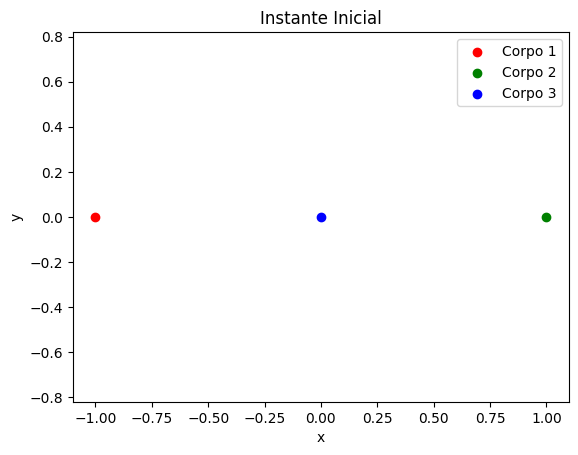

In [ ]:
fig = plt.figure()
ax = plt.axes()

i=0
ax.scatter(history[i,0,0], history[i,0,1], color='red', label='Corpo 1')
ax.scatter(history[i,1,0], history[i,1,1], color='green', label='Corpo 2')
ax.scatter(history[i,2,0], history[i,2,1], color='blue', label='Corpo 3')

plt.axis('equal')
plt.title("Instante Inicial")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

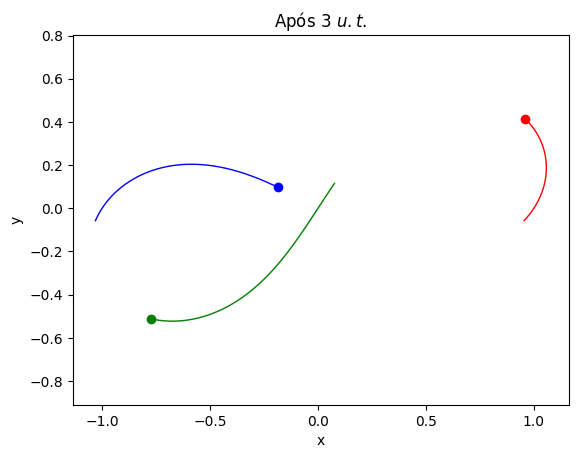

In [ ]:
fig = plt.figure()
ax = plt.axes()

j=-1000
ax.plot(history[j:,0,0], history[j:,0,1], color='red', linewidth=1)
ax.plot(history[j:,1,0], history[j:,1,1], color='green', linewidth=1)
ax.plot(history[j:,2,0], history[j:,2,1], color='blue', linewidth=1)

i=-1
ax.scatter(history[i,0,0], history[i,0,1], color='red', label='Corpo 1')
ax.scatter(history[i,1,0], history[i,1,1], color='green', label='Corpo 2')
ax.scatter(history[i,2,0], history[i,2,1], color='blue', label='Corpo 3')

plt.axis('equal')
plt.title("Após $3 \ u.t.$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

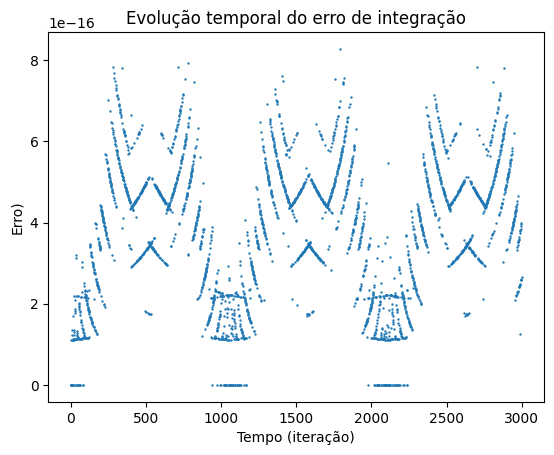

In [ ]:
fig = plt.figure()
ax = plt.axes()

plt.scatter(t/0.001, stats[:,1], 0.5)

plt.xlabel("Tempo (iteração)")
plt.ylabel("Erro)")
plt.title("Evolução temporal do erro de integração")
plt.show()

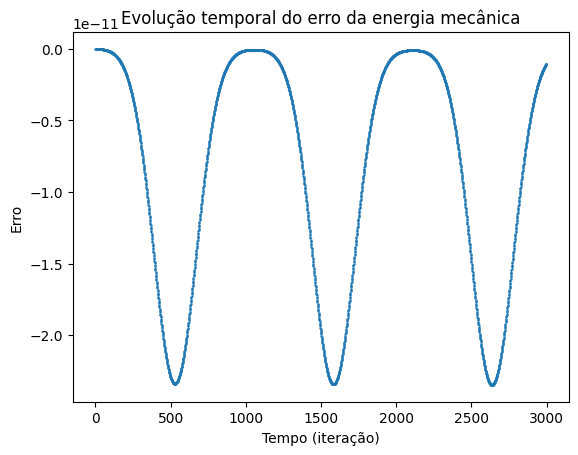

In [ ]:
fig = plt.figure()
ax = plt.axes()

Em0 = energies[0,2]
eps_Em = abs(energies[:,2] - Em0) / Em0

plt.scatter(t/0.001, eps_Em, 0.5)

plt.xlabel("Tempo (iteração)")
plt.ylabel("Erro")
plt.title("Evolução temporal do erro da energia mecânica")
plt.show()

### Animação

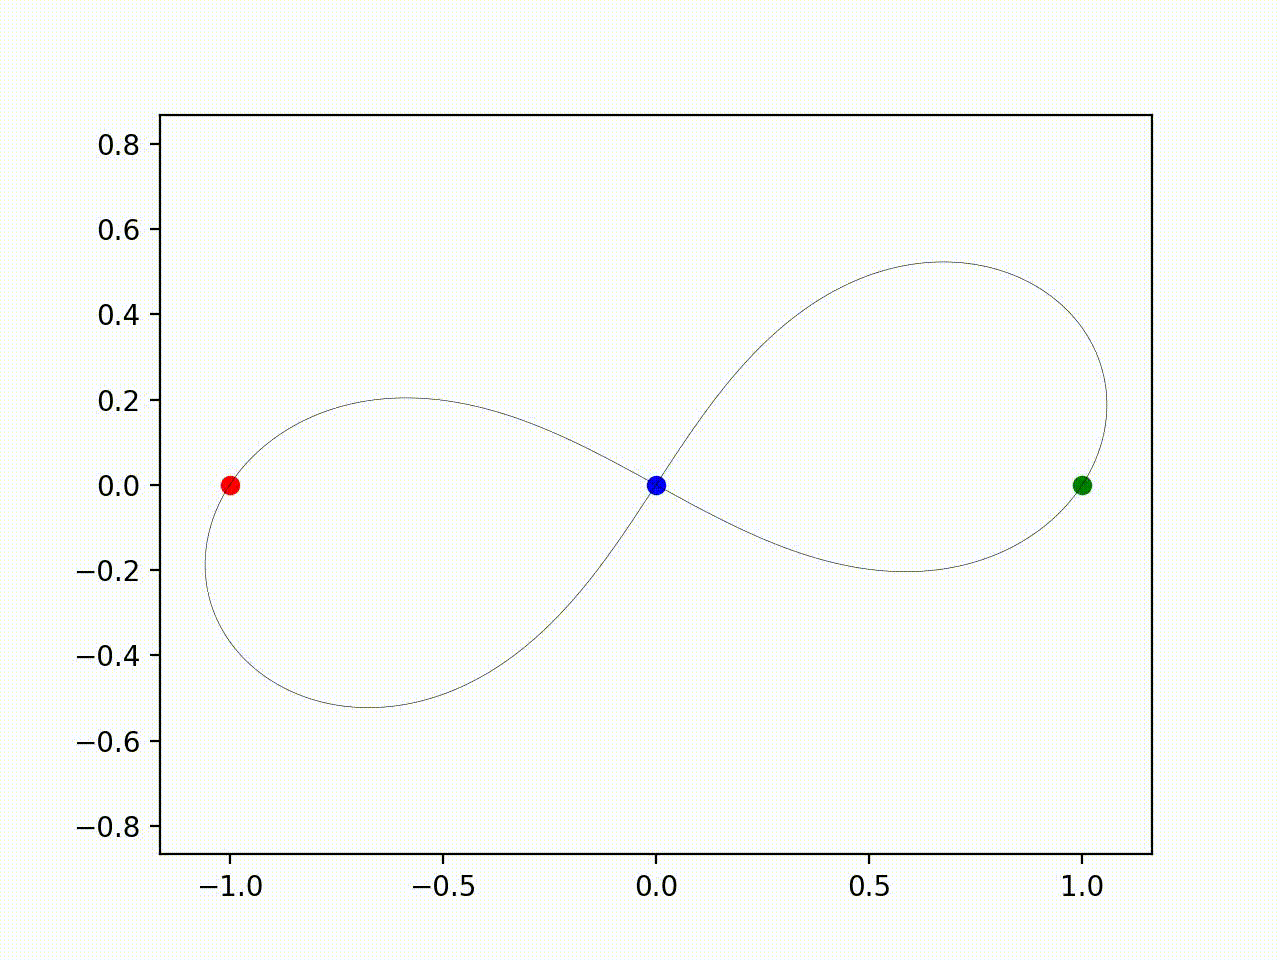